In [55]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dropout, Dense, LSTM, GRU, SimpleRNN
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [56]:
dataset = pd.read_csv("XAU_USD-Historical-Data.csv", parse_dates=['Date'])

In [57]:
dataset.head()

,Date,Close,Open,High,Low,% Change
0,2005-01-04,427.65,429.6,427.65,427.65,-0.30%
1,2005-01-05,426.55,427.55,426.55,426.55,-0.26%
2,2005-01-06,421.32,426.77,421.32,421.32,-1.23%
3,2005-01-07,418.95,421.75,418.95,418.95,-0.56%
4,2005-01-10,419.12,419.38,419.12,419.12,0.04%


In [58]:
column_list = ['Close', 'Open', 'High', 'Low']
for column in column_list:
    dataset[column] = dataset[column].replace({',': ''}, regex=True)
dataset[column_list] = dataset[column_list].astype(float)

column_list = ['% Change']
for column in column_list:
    dataset[column] = dataset[column].replace({'%': ''}, regex=True)
dataset[column_list] = dataset[column_list].astype(float)

dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4962 entries, 0 to 4961
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      4962 non-null   datetime64[ns]
 1   Close     4962 non-null   float64       
 2   Open      4962 non-null   float64       
 3   High      4962 non-null   float64       
 4   Low       4962 non-null   float64       
 5   % Change  4962 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 232.7 KB


In [59]:
dataset.describe()

,Date,Close,Open,High,Low,% Change
count,4962,4962.000000,4962.000000,4962.000000,4962.000000,4962.000000
mean,2014-07-13 13:12:15.671100160,1286.054716,1285.885510,1295.350516,1276.531919,0.037066
min,2005-01-04 00:00:00,412.800000,412.570000,412.800000,412.800000,-8.490000
25%,2009-10-08 06:00:00,1040.312500,1038.300000,1045.500000,1028.825000,-0.490000
50%,2014-07-12 12:00:00,1283.525000,1283.395000,1290.270000,1276.885000,0.040000
75%,2019-04-17 18:00:00,1652.032500,1653.132500,1665.365000,1639.372500,0.590000
max,2024-01-22 00:00:00,2077.000000,2077.340000,2135.720000,2065.890000,11.000000
std,NaN,423.769816,423.961485,426.640735,420.946641,1.074692


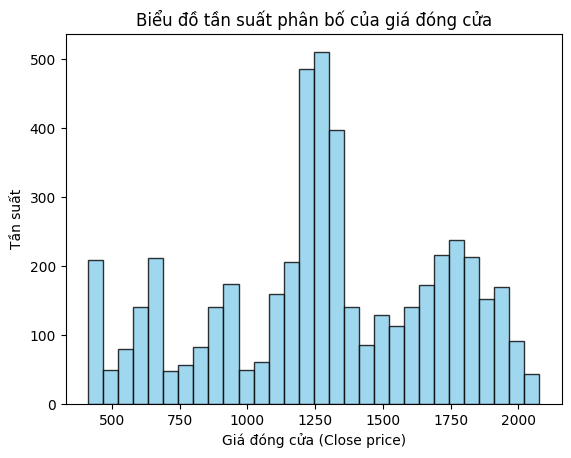

In [60]:
import matplotlib.pyplot as plt

plt.hist(dataset['Close'], bins= 30, color='skyblue', edgecolor='black', alpha=0.8)
plt.xlabel('Giá đóng cửa (Close price)')
plt.ylabel('Tần suất')
plt.title('Biểu đồ tần suất phân bố của giá đóng cửa')
plt.show()

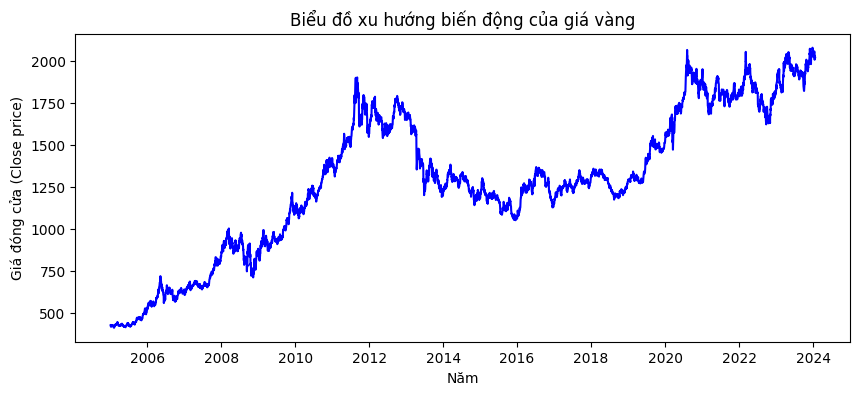

In [61]:
plt.figure(figsize=(10, 4))
plt.plot(dataset['Date'], dataset['Close'], color='b', linestyle='-')
plt.xlabel('Năm')
plt.ylabel('Giá đóng cửa (Close price)')
plt.title('Biểu đồ xu hướng biến động của giá vàng')
plt.grid(False)
plt.show()

              Date     Close      Open      High       Low  % Change
Date      1.000000  0.829744  0.829783  0.828445  0.831785 -0.018351
Close     0.829744  1.000000  0.999477  0.999733  0.999771 -0.003613
Open      0.829783  0.999477  1.000000  0.999777  0.999695 -0.033828
High      0.828445  0.999733  0.999777  1.000000  0.999608 -0.019614
Low       0.831785  0.999771  0.999695  0.999608  1.000000 -0.016760
% Change -0.018351 -0.003613 -0.033828 -0.019614 -0.016760  1.000000


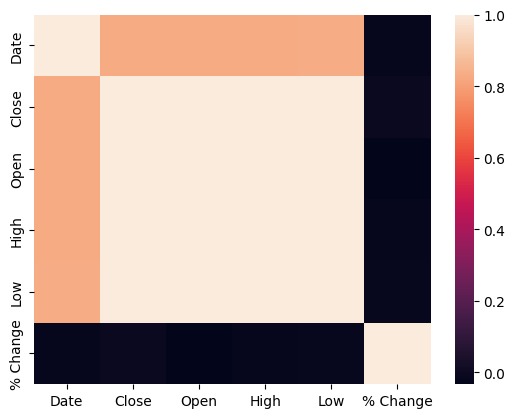

In [62]:
print(dataset.corr())
sns.heatmap(dataset.corr())
plt.show()

In [63]:
close = dataset.filter(['Close'])
numpy_close = close.values

train_data_len = math.ceil(len(numpy_close)*.8)

train_data_len

3970

In [64]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_close = scaler.fit_transform(close)
scaled_close

array([[0.00892321],
       [0.00826223],
       [0.00511958],
       ...,
       [0.96735368],
       [0.97121139],
       [0.96580339]])

In [65]:
train_data = scaled_close[0:train_data_len, :]

x_train = []
y_train = []

for i in range(60, len(train_data)):
  x_train.append(train_data[i-60:i, 0])
  y_train.append(train_data[i, 0])
  if i == 60:
    print(x_train)
    print(y_train)

[array([0.00892321, 0.00826223, 0.00511958, 0.00369547, 0.00379762,
       0.00575652, 0.00800385, 0.00740296, 0.0062192 , 0.00575652,
       0.00615912, 0.00603894, 0.00585867, 0.00838241, 0.00869487,
       0.00578656, 0.00823218, 0.00805192, 0.00841245, 0.00590073,
       0.00498738, 0.00551616, 0.00258382, 0.0010816 , 0.00084125,
       0.        , 0.00019228, 0.00289629, 0.00485519, 0.00785963,
       0.0077034 , 0.00755919, 0.00880303, 0.00879101, 0.00874294,
       0.01306934, 0.0130393 , 0.01281096, 0.01329768, 0.01371229,
       0.01198774, 0.01192765, 0.01049754, 0.01273885, 0.0131114 ,
       0.01671674, 0.01671674, 0.01777431, 0.01985939, 0.01705324,
       0.01687297, 0.01853744, 0.01540079, 0.01595361, 0.0111465 ,
       0.00868285, 0.00724072, 0.00736089, 0.00808196, 0.00785963])]
[0.00816007691383247]


In [66]:
x_train, y_train = np.array(x_train), np.array(y_train)

In [67]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(3910, 60, 1)

In [68]:
test_data = scaled_close[train_data_len-60:, :]

x_test = []
y_test = numpy_close[train_data_len:, :]

for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])

In [69]:
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [70]:
def change(close, pred_close):
    return ((pred_close - close)/close)*100

In [71]:
MODEL = []
PRED = []

In [72]:
lstm = tf.keras.Sequential()
lstm.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
lstm.add(LSTM(50, return_sequences=False))
lstm.add(Dense(25))
lstm.add(Dense(1))

optimizer = Adam(learning_rate=0.001)
lstm.compile(optimizer=optimizer, loss='mse')

In [73]:
lstm.fit(x_train, y_train, batch_size=32, epochs=10)

Epoch 1/10
123/123 [==============================] - 18s 57ms/step - loss: 0.0093
Epoch 2/10
123/123 [==============================] - 7s 57ms/step - loss: 3.3693e-04
Epoch 3/10
123/123 [==============================] - 6s 52ms/step - loss: 3.2061e-04
Epoch 4/10
123/123 [==============================] - 7s 53ms/step - loss: 3.1932e-04
Epoch 5/10
123/123 [==============================] - 6s 51ms/step - loss: 3.1253e-04
Epoch 6/10
123/123 [==============================] - 7s 58ms/step - loss: 3.0071e-04
Epoch 7/10
123/123 [==============================] - 7s 56ms/step - loss: 2.8296e-04
Epoch 8/10
123/123 [==============================] - 6s 50ms/step - loss: 2.8419e-04
Epoch 9/10
123/123 [==============================] - 7s 54ms/step - loss: 2.6879e-04
Epoch 10/10
123/123 [==============================] - 7s 53ms/step - loss: 2.6295e-04


In [74]:
lstm.save('lstm_model.h5')

C:\Users\T480s\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [75]:
lstm_pred = lstm.predict(x_test)
lstm_pred = scaler.inverse_transform(lstm_pred)

31/31 [==============================] - 2s 20ms/step


In [76]:
MODEL.append('LSTM')
PRED.append(lstm_pred)

In [77]:
change_pred = []
index = -1
for i in lstm_pred:
    change_pred.append(change(numpy_close[train_data_len+index], i))
    index += 1

change_val = dataset.filter(['% Change']).values
mse = mean_squared_error(change_val[train_data_len:], change_pred)
mse

3.0322538574939273

In [78]:
cnn = tf.keras.Sequential()
cnn.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(x_train.shape[1], 1)))
cnn.add(MaxPooling1D(pool_size=2))
cnn.add(Flatten())
cnn.add(Dense(64))
cnn.add(Dense(1))

optimizer = Adam(learning_rate=0.002)
cnn.compile(optimizer='adam', loss='mse')

In [79]:
cnn.fit(x_train, y_train, batch_size=32, epochs=10)

Epoch 1/10
123/123 [==============================] - 1s 4ms/step - loss: 0.0069
Epoch 2/10
123/123 [==============================] - 0s 4ms/step - loss: 4.7654e-04
Epoch 3/10
123/123 [==============================] - 0s 4ms/step - loss: 3.3546e-04
Epoch 4/10
123/123 [==============================] - 0s 4ms/step - loss: 2.9286e-04
Epoch 5/10
123/123 [==============================] - 1s 4ms/step - loss: 2.8955e-04
Epoch 6/10
123/123 [==============================] - 1s 4ms/step - loss: 2.5557e-04
Epoch 7/10
123/123 [==============================] - 1s 4ms/step - loss: 2.3709e-04
Epoch 8/10
123/123 [==============================] - 1s 4ms/step - loss: 2.9463e-04
Epoch 9/10
123/123 [==============================] - 0s 4ms/step - loss: 2.2100e-04
Epoch 10/10
123/123 [==============================] - 0s 4ms/step - loss: 2.1401e-04


In [80]:
cnn.save('cnn_model.h5')

C:\Users\T480s\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [81]:
cnn_pred = cnn.predict(x_test)
cnn_pred = scaler.inverse_transform(cnn_pred)

31/31 [==============================] - 0s 3ms/step


In [82]:
MODEL.append('CNN')
PRED.append(cnn_pred)

In [83]:
rnn = tf.keras.models.Sequential()
rnn.add(SimpleRNN(units=50, activation='relu', input_shape=(x_train.shape[1], 1)))
rnn.add(Dense(units=1))

optimizer = Adam(learning_rate=0.0016)
rnn.compile(optimizer='adam', loss='mse')

In [84]:
rnn.fit(x_train, y_train, batch_size=32, epochs=10)

Epoch 1/10
123/123 [==============================] - 3s 11ms/step - loss: 0.0079
Epoch 2/10
123/123 [==============================] - 1s 12ms/step - loss: 7.6589e-05
Epoch 3/10
123/123 [==============================] - 1s 11ms/step - loss: 7.6185e-05
Epoch 4/10
123/123 [==============================] - 2s 12ms/step - loss: 7.8455e-05
Epoch 5/10
123/123 [==============================] - 2s 12ms/step - loss: 7.6632e-05
Epoch 6/10
123/123 [==============================] - 1s 12ms/step - loss: 7.1931e-05
Epoch 7/10
123/123 [==============================] - 2s 12ms/step - loss: 7.6556e-05
Epoch 8/10
123/123 [==============================] - 2s 14ms/step - loss: 7.2909e-05
Epoch 9/10
123/123 [==============================] - 2s 13ms/step - loss: 7.0427e-05
Epoch 10/10
123/123 [==============================] - 1s 12ms/step - loss: 7.4812e-05


In [85]:
rnn.save('rnn_model.h5')

C:\Users\T480s\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [86]:
rnn_pred = rnn.predict(x_test)
rnn_pred = scaler.inverse_transform(rnn_pred)

31/31 [==============================] - 0s 6ms/step


In [87]:
MODEL.append('RNN')
PRED.append(rnn_pred)

In [88]:
gru = tf.keras.models.Sequential()
gru.add(GRU(units=50, activation='tanh', input_shape=(x_train.shape[1], 1)))
gru.add(Dense(units=1))

optimizer = Adam(learning_rate=0.002)
gru.compile(optimizer=optimizer, loss='mean_squared_error')

In [89]:
gru.fit(x_train, y_train, batch_size=32, epochs=10)

Epoch 1/10
123/123 [==============================] - 5s 24ms/step - loss: 0.0116
Epoch 2/10
123/123 [==============================] - 3s 22ms/step - loss: 1.0250e-04
Epoch 3/10
123/123 [==============================] - 3s 23ms/step - loss: 9.3101e-05
Epoch 4/10
123/123 [==============================] - 3s 26ms/step - loss: 8.5458e-05
Epoch 5/10
123/123 [==============================] - 4s 29ms/step - loss: 8.2000e-05
Epoch 6/10
123/123 [==============================] - 6s 49ms/step - loss: 7.9108e-05
Epoch 7/10
123/123 [==============================] - 6s 52ms/step - loss: 8.5349e-05
Epoch 8/10
123/123 [==============================] - 7s 55ms/step - loss: 7.9025e-05
Epoch 9/10
123/123 [==============================] - 6s 49ms/step - loss: 7.7621e-05
Epoch 10/10
123/123 [==============================] - 6s 47ms/step - loss: 7.1699e-05


In [90]:
gru.save('gru_model.h5')

C:\Users\T480s\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [91]:
gru_pred = gru.predict(x_test)
gru_pred = scaler.inverse_transform(gru_pred)

31/31 [==============================] - 2s 14ms/step


In [92]:
MODEL.append('GRU')
PRED.append(gru_pred)

In [93]:
change_pred = []
index = -1
for i in gru_pred:
    change_pred.append(change(numpy_close[train_data_len+index], i))
    index += 1

change_val = dataset.filter(['% Change']).values
mse = mean_squared_error(change_val[train_data_len:], change_pred)
mse

1.083899128260926

In [94]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    
    # Normalization and Attention
    # "EMBEDDING LAYER"
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    
    # "ATTENTION LAYER"
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs
    
    # FEED FORWARD Part - you can stick anything here or just delete the whole section - it will still work. 
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation = "relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [95]:
def build_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout=0, mlp_dropout=0):
    inputs = tf.keras.Input(shape=input_shape)
    x = inputs
    
    for _ in range(num_transformer_blocks):  # This is what stacks our transformer blocks
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="elu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1, activation="linear")(x) #this is a pass-through
    return tf.keras.Model(inputs, outputs)

In [96]:
transformer = build_model(
    input_shape=(x_train.shape[1], 1),
    head_size=46, # Embedding size for attention
    num_heads=60, # Number of attention heads
    ff_dim=55, # Hidden layer size in feed forward network inside transformer
    num_transformer_blocks=5,
    mlp_units=[256],
    mlp_dropout=0.4,
    dropout=0.2,
)

optimizer = Adam(learning_rate=0.002)
transformer.compile(optimizer=optimizer, loss="mse")

In [97]:
transformer.fit(x_train, y_train, batch_size=32, epochs=10)

Epoch 1/10
123/123 [==============================] - 233s 2s/step - loss: 0.0595
Epoch 2/10
123/123 [==============================] - 204s 2s/step - loss: 0.0067
Epoch 3/10
123/123 [==============================] - 199s 2s/step - loss: 0.0029
Epoch 4/10
123/123 [==============================] - 197s 2s/step - loss: 0.0021
Epoch 5/10
123/123 [==============================] - 191s 2s/step - loss: 0.0014
Epoch 6/10
123/123 [==============================] - 190s 2s/step - loss: 0.0012
Epoch 7/10
123/123 [==============================] - 188s 2s/step - loss: 0.0014
Epoch 8/10
123/123 [==============================] - 5150s 42s/step - loss: 0.0017
Epoch 9/10
123/123 [==============================] - 190s 2s/step - loss: 0.0013
Epoch 10/10
123/123 [==============================] - 195s 2s/step - loss: 0.0014


In [98]:
transformer.save('transformer_model.h5')

C:\Users\T480s\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [99]:
tfm_pred = transformer.predict(x_test)
tfm_pred = scaler.inverse_transform(tfm_pred)

31/31 [==============================] - 9s 256ms/step


In [100]:
MODEL.append('Tranformer')
PRED.append(tfm_pred)

In [101]:
model = tf.keras.models.Sequential()
model.add(SimpleRNN(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(GRU(50, return_sequences=False))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(x_train, y_train, batch_size=32, epochs=10)
rnngru_pred = model.predict(x_test)
rnngru_pred = scaler.inverse_transform(rnngru_pred)

Epoch 1/10
123/123 [==============================] - 8s 38ms/step - loss: 0.0018
Epoch 2/10
123/123 [==============================] - 5s 41ms/step - loss: 1.6825e-04
Epoch 3/10
123/123 [==============================] - 4s 33ms/step - loss: 1.3228e-04
Epoch 4/10
123/123 [==============================] - 4s 33ms/step - loss: 1.3514e-04
Epoch 5/10
123/123 [==============================] - 4s 29ms/step - loss: 1.3716e-04
Epoch 6/10
123/123 [==============================] - 4s 31ms/step - loss: 1.0382e-04
Epoch 7/10
123/123 [==============================] - 4s 33ms/step - loss: 9.5754e-05
Epoch 8/10
123/123 [==============================] - 4s 31ms/step - loss: 9.6458e-05
Epoch 9/10
123/123 [==============================] - 4s 31ms/step - loss: 9.9677e-05
Epoch 10/10
31/31 [==============================] - 1s 11ms/step


In [102]:
MODEL.append('RNN-GRU')
PRED.append(rnngru_pred)

In [103]:
model = tf.keras.models.Sequential()

model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')


In [104]:
model.fit(x_train, y_train, batch_size=32, epochs=10)
cnnlstm_pred = model.predict(x_test)
cnnlstm_pred = scaler.inverse_transform(cnnlstm_pred)

Epoch 1/10
123/123 [==============================] - 3s 12ms/step - loss: 0.0159
Epoch 2/10
123/123 [==============================] - 2s 13ms/step - loss: 3.4458e-04
Epoch 3/10
123/123 [==============================] - 2s 14ms/step - loss: 3.1689e-04
Epoch 4/10
123/123 [==============================] - 2s 13ms/step - loss: 3.0158e-04
Epoch 5/10
123/123 [==============================] - 2s 13ms/step - loss: 2.9297e-04
Epoch 6/10
123/123 [==============================] - 2s 13ms/step - loss: 2.8035e-04
Epoch 7/10
123/123 [==============================] - 2s 12ms/step - loss: 2.7671e-04
Epoch 8/10
123/123 [==============================] - 2s 13ms/step - loss: 2.4111e-04
Epoch 9/10
123/123 [==============================] - 2s 15ms/step - loss: 2.2165e-04
Epoch 10/10
31/31 [==============================] - 0s 6ms/step


In [105]:
MODEL.append('CNN-LSTM')
PRED.append(cnnlstm_pred)

In [106]:
for i in range(len(MODEL)):
    print('\t---' + MODEL[i] + '---')
    pred = PRED[i]
    r2 = r2_score(pred, y_test)
    print('R2 score: ', r2)
    mse = mean_squared_error(pred, y_test)
    print('MSE: ', mse)
    rmse = np.sqrt(mse)
    print('RMSE: ', rmse)
    mae = mean_absolute_error(pred, y_test)
    print('MAE: ', mae)

	---LSTM---
R2 score:  0.8856017905613968
MSE:  1025.1108227761183
RMSE:  32.01735190136933
MAE:  24.55589040448589
	---CNN---
R2 score:  0.9237985865041671
MSE:  706.0988493093562
RMSE:  26.572520567483924
MAE:  20.283330841064455
	---RNN---
R2 score:  0.9600337181066179
MSE:  388.51188437780013
RMSE:  19.710704816870454
MAE:  15.29331683743385
	---GRU---
R2 score:  0.9613189105194753
MSE:  373.29205873363634
RMSE:  19.320767550323573
MAE:  14.49908388199345
	---Tranformer---
R2 score:  0.9160586780172485
MSE:  749.421319970744
RMSE:  27.37556063299424
MAE:  21.47223331574471
	---RNN-GRU---
R2 score:  0.9057819364606801
MSE:  814.73562236239
RMSE:  28.543574099302806
MAE:  24.086857097994898
	---CNN-LSTM---
R2 score:  0.9037871756369155
MSE:  837.6894001534359
RMSE:  28.942864408234303
MAE:  22.439436665196578


C:\Users\T480s\AppData\Local\Temp\ipykernel_32872\2448376769.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Pred'] = PRED[i]
C:\Users\T480s\AppData\Local\Temp\ipykernel_32872\2448376769.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Date'] = dataset.filter(['Date'])


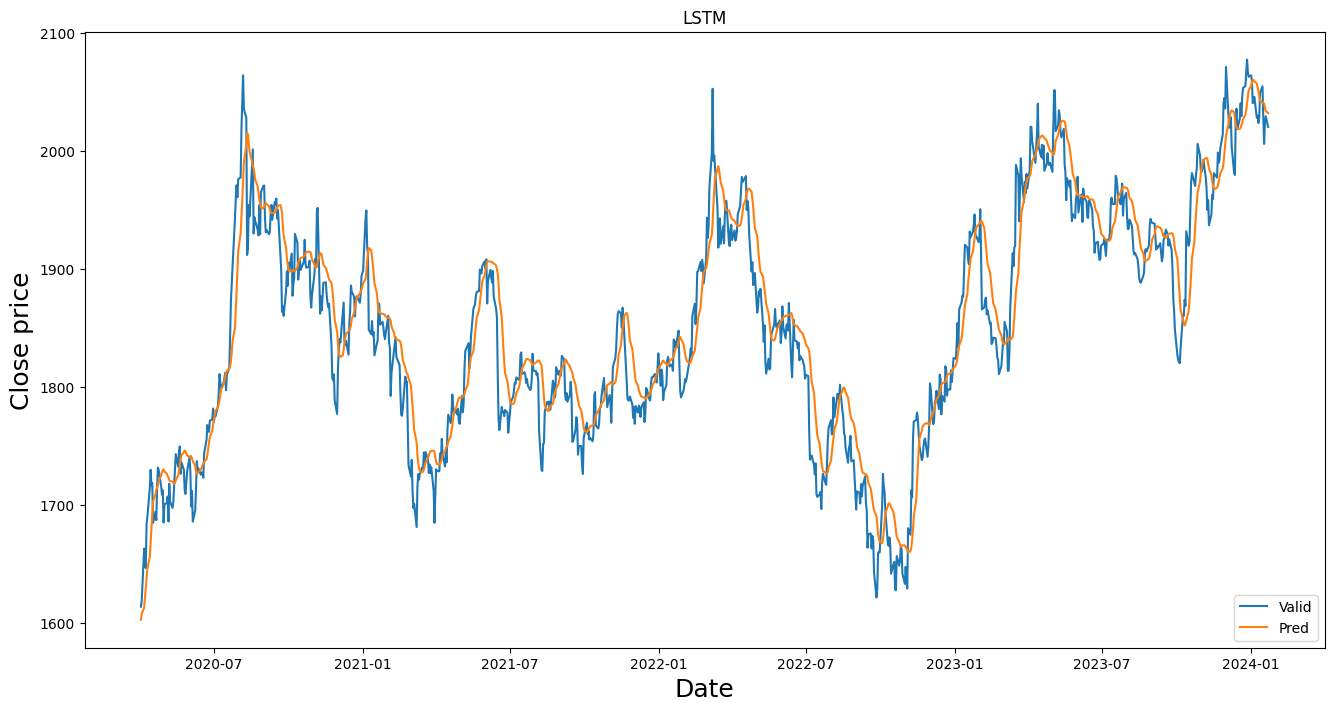

C:\Users\T480s\AppData\Local\Temp\ipykernel_32872\2448376769.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Pred'] = PRED[i]
C:\Users\T480s\AppData\Local\Temp\ipykernel_32872\2448376769.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Date'] = dataset.filter(['Date'])


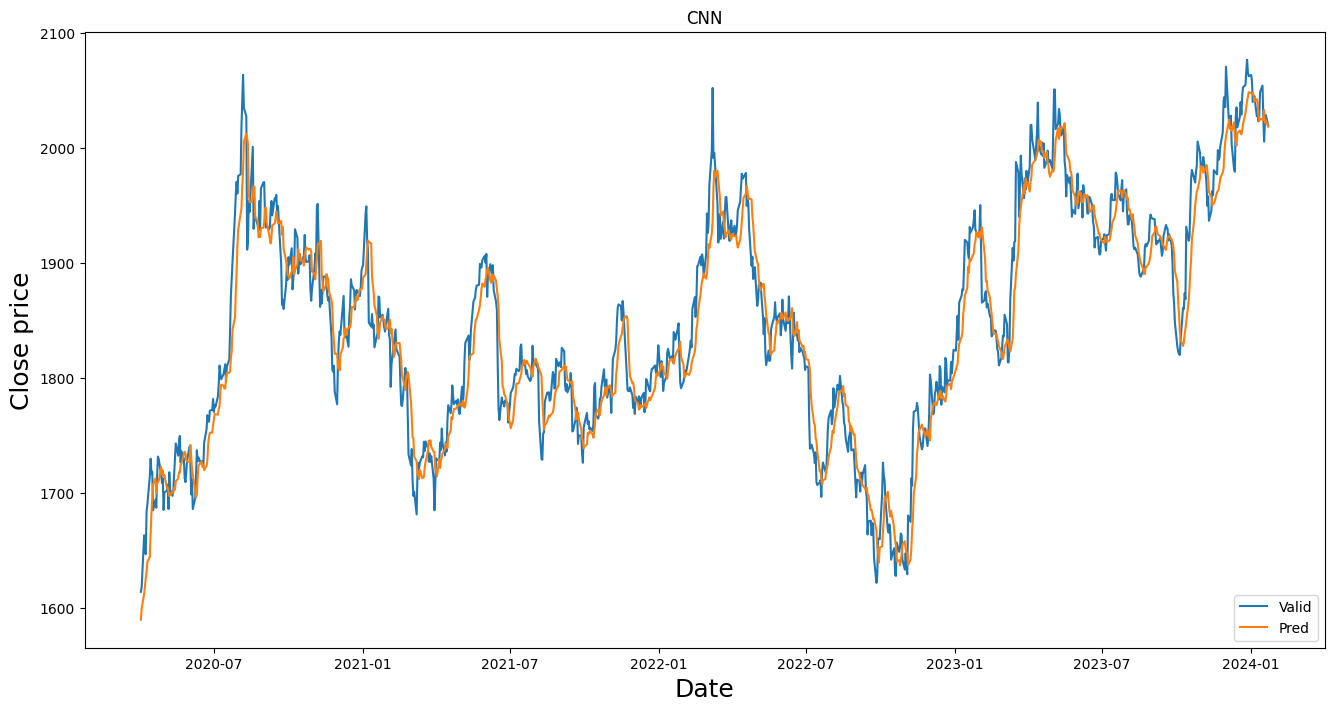

C:\Users\T480s\AppData\Local\Temp\ipykernel_32872\2448376769.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Pred'] = PRED[i]
C:\Users\T480s\AppData\Local\Temp\ipykernel_32872\2448376769.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Date'] = dataset.filter(['Date'])


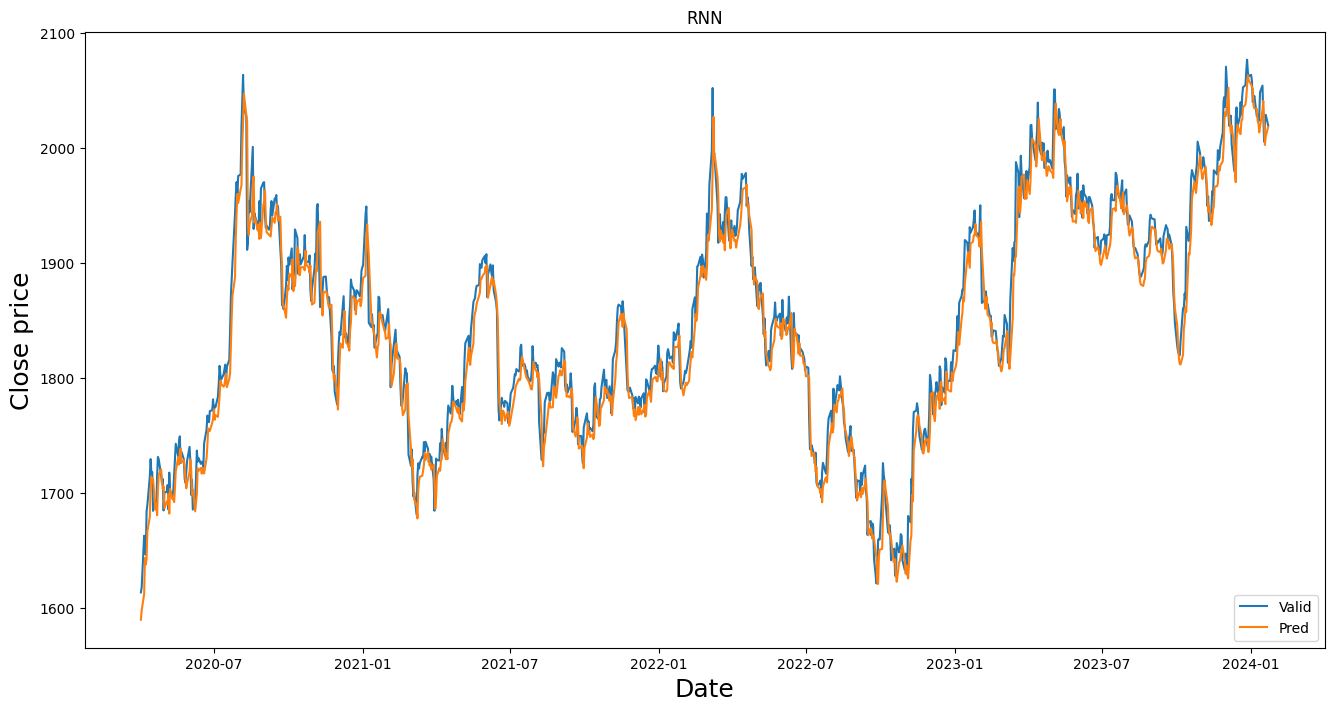

C:\Users\T480s\AppData\Local\Temp\ipykernel_32872\2448376769.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Pred'] = PRED[i]
C:\Users\T480s\AppData\Local\Temp\ipykernel_32872\2448376769.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Date'] = dataset.filter(['Date'])


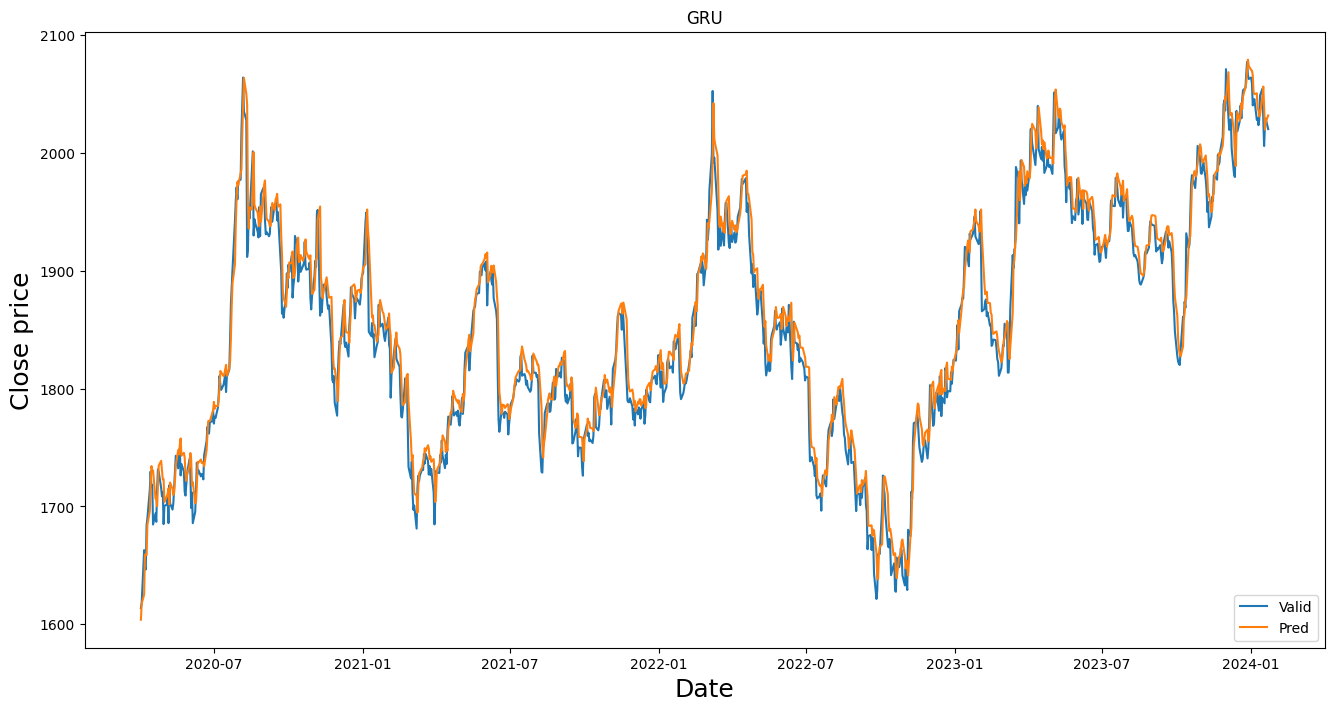

C:\Users\T480s\AppData\Local\Temp\ipykernel_32872\2448376769.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Pred'] = PRED[i]
C:\Users\T480s\AppData\Local\Temp\ipykernel_32872\2448376769.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Date'] = dataset.filter(['Date'])


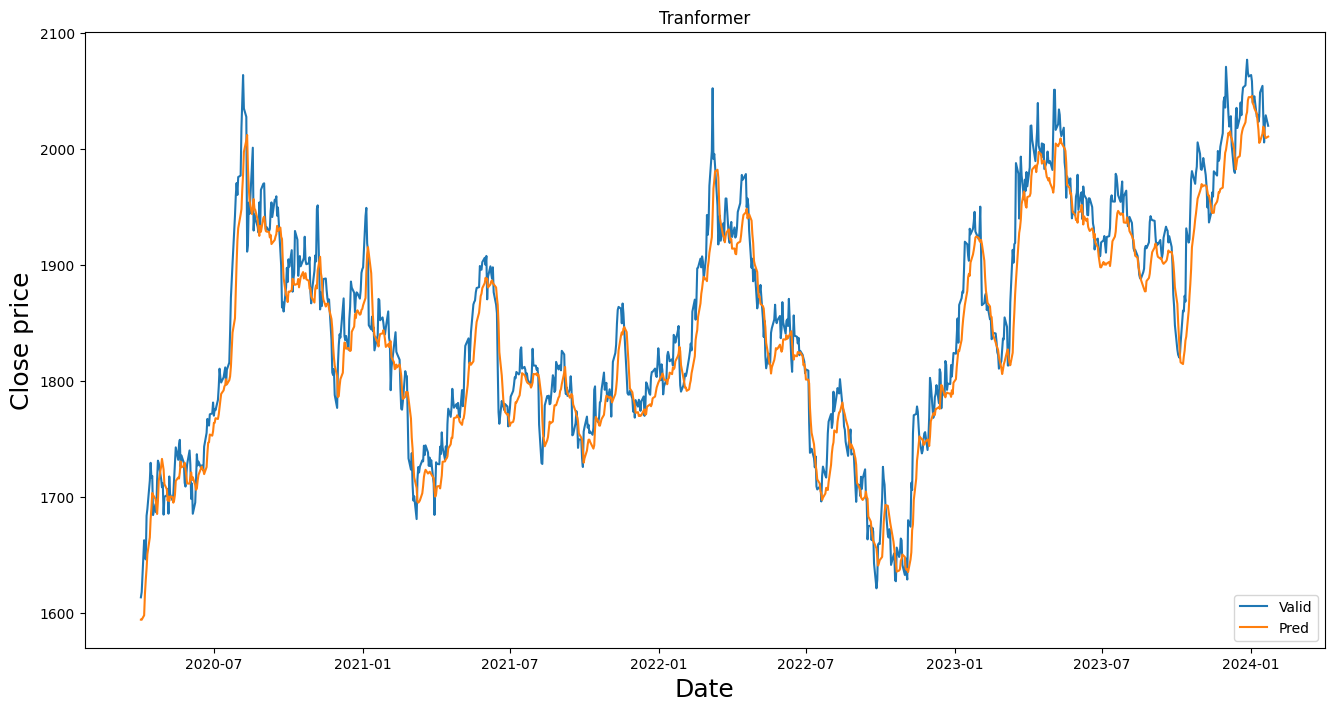

C:\Users\T480s\AppData\Local\Temp\ipykernel_32872\2448376769.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Pred'] = PRED[i]
C:\Users\T480s\AppData\Local\Temp\ipykernel_32872\2448376769.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Date'] = dataset.filter(['Date'])


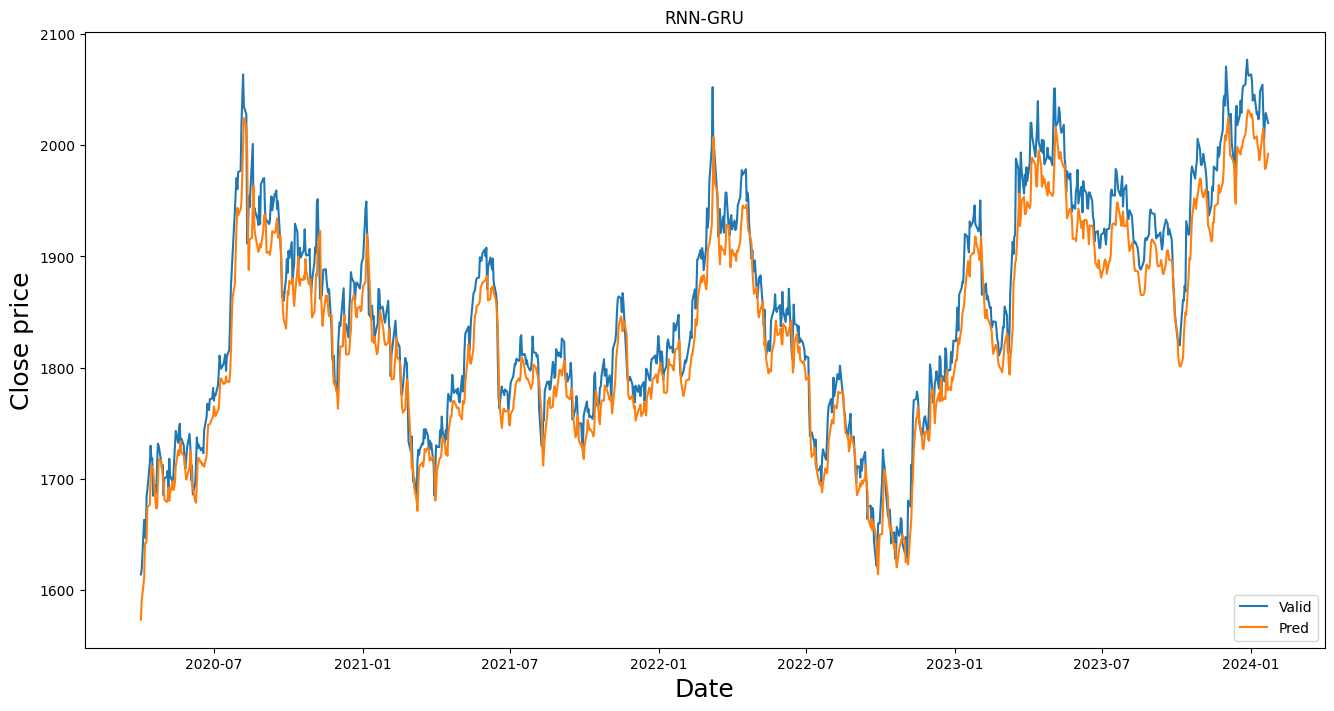

C:\Users\T480s\AppData\Local\Temp\ipykernel_32872\2448376769.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Pred'] = PRED[i]
C:\Users\T480s\AppData\Local\Temp\ipykernel_32872\2448376769.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Date'] = dataset.filter(['Date'])


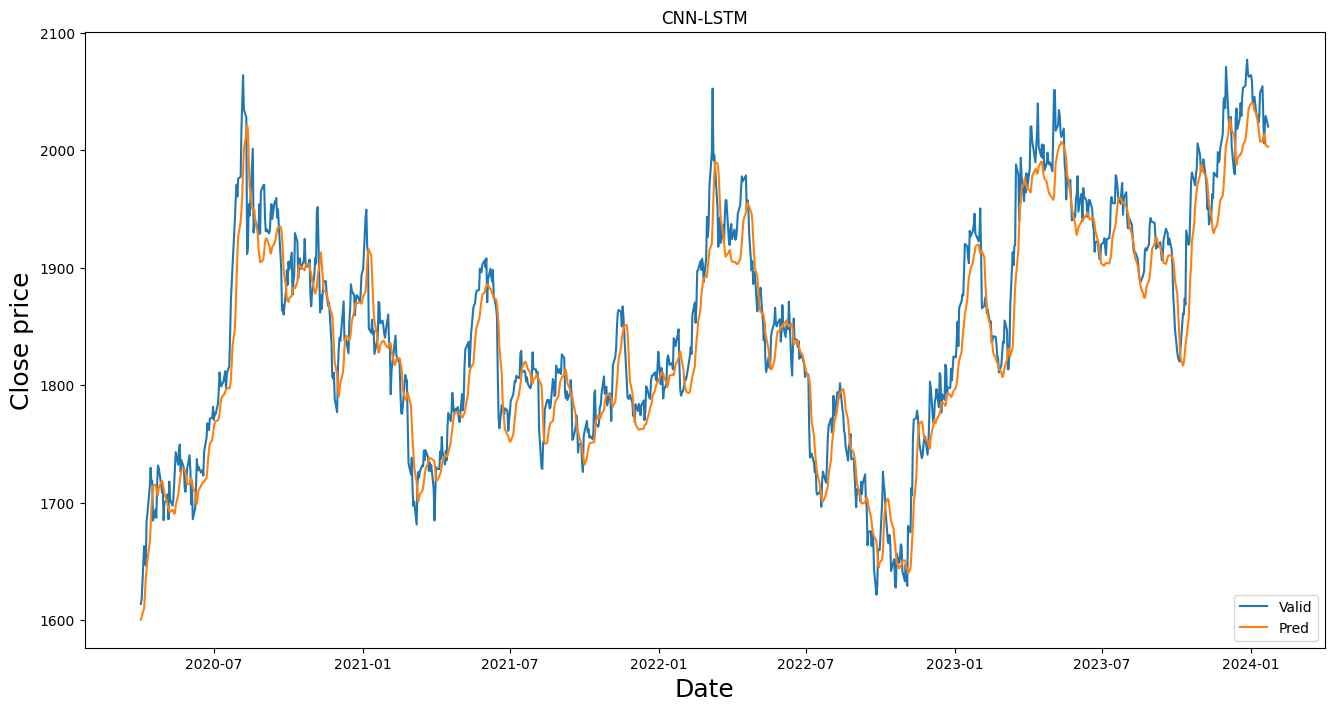

In [107]:
for i in range(len(MODEL)):
    valid = close[train_data_len:]
    valid['Pred'] = PRED[i]
    valid['Date'] = dataset.filter(['Date'])

    plt.figure(figsize=(16, 8))
    plt.plot(valid['Date'], valid['Close'], label='Valid')
    plt.plot(valid['Date'], valid['Pred'], label='Pred')
    plt.title(MODEL[i])
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close price', fontsize=18)
    plt.legend(loc='lower right')
    plt.show()

C:\Users\T480s\AppData\Local\Temp\ipykernel_32872\1413249048.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['LSTM'] = lstm_pred
C:\Users\T480s\AppData\Local\Temp\ipykernel_32872\1413249048.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['CNN'] = cnn_pred
C:\Users\T480s\AppData\Local\Temp\ipykernel_32872\1413249048.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

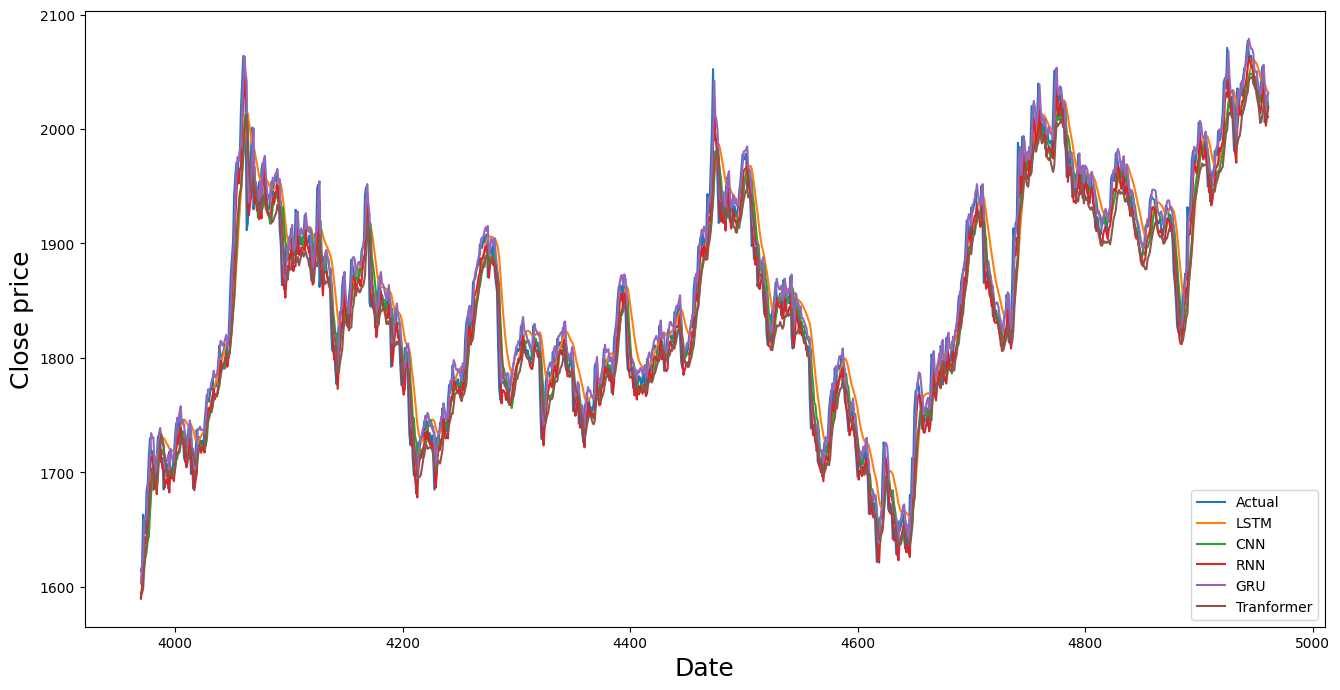

In [108]:
valid = close[train_data_len:]
valid['LSTM'] = lstm_pred
valid['CNN'] = cnn_pred
valid['RNN'] = rnn_pred
valid['GRU'] = gru_pred
valid['Tranformer'] = tfm_pred

plt.figure(figsize=(16,8))
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close price', fontsize=18)
plt.plot(valid[['Close', 'LSTM', 'CNN', 'RNN', 'GRU', 'Tranformer']])
plt.legend(['Actual', 'LSTM', 'CNN', 'RNN', 'GRU', 'Tranformer'], loc='lower right')
plt.show()

In [109]:
for i in range(len(MODEL)):
    change_pred = []
    index = -1
    for p in PRED[i]:
        change_pred.append(change(numpy_close[train_data_len+index], p))
        index += 1

    change_val = dataset.filter(['% Change']).values
    mse = mean_squared_error(change_val[train_data_len:], change_pred)
    print('MSE of % change with ' + MODEL[i] + ' model: ', mse)

MSE of % change with LSTM model:  3.0322538574939273
MSE of % change with CNN model:  2.0561264990261585
MSE of % change with RNN model:  1.1334640174196666
MSE of % change with GRU model:  1.083899128260926
MSE of % change with Tranformer model:  2.152260654638723
MSE of % change with RNN-GRU model:  2.3188747961271354
MSE of % change with CNN-LSTM model:  2.4000961905457583
